In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import matplotlib.pyplot as plt
import torch

from agent import Agent, add_noise
from hill_climbing import perform_hill_climbing

https://openai.com/requests-for-research/#cartpole

## Explore `gym` and the `CartPole-v0` environment

In [3]:
env = gym.envs.make('CartPole-v0')

/home/mkurovski/anaconda3/envs/drl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
env.reset()

array([ 0.02687121,  0.01016242,  0.03069582, -0.03415769])

In [5]:
env.action_space

Discrete(2)

In [6]:
env.observation_space

Box(4,)

Watch an untrained agent

In [7]:
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
cartpole_agent.watch_me(env, steps=300)

## Apply Hill Climbing Algorithm to solve Environment

In [8]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 2000
initial_noise_std = 0.01

In [9]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  initial_noise_std=initial_noise_std,
                                                  population_size=1)

Start with Return Estimate G = 40.0
Episode 3 - Improved G to G_best = 45.0
Episode 18 - Improved G to G_best = 47.0
Episode 30 - Improved G to G_best = 48.0
Episode 36 - Improved G to G_best = 64.0
Episode 228 - Improved G to G_best = 75.0
Episode 345 - Improved G to G_best = 106.0
Episode 1952 - Improved G to G_best = 108.0


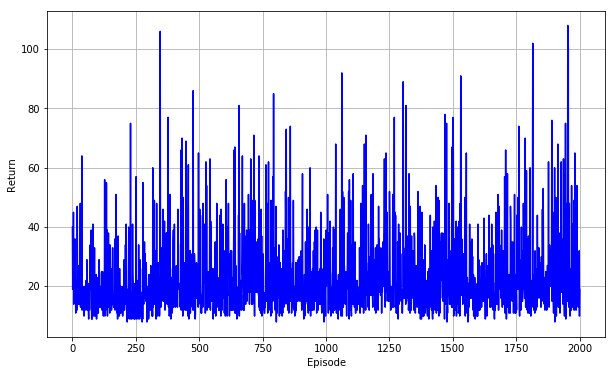

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

Watch a (slightly) improved agent

In [11]:
opt_agent.watch_me(env, steps=300)

## Change over to Steepest Ascent Hill Climbing and its Flavors

### without adaptive noise

In [12]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 250
initial_noise_std = 0.01
population_size = 30
use_adaptive_noise = False

In [13]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise)

Start with Return Estimate G = 28.0
Episode 0 - Improved G to G_best = 60.0
Episode 8 - Improved G to G_best = 104.0
Episode 182 - Improved G to G_best = 112.0
Episode 200 - Improved G to G_best = 124.0


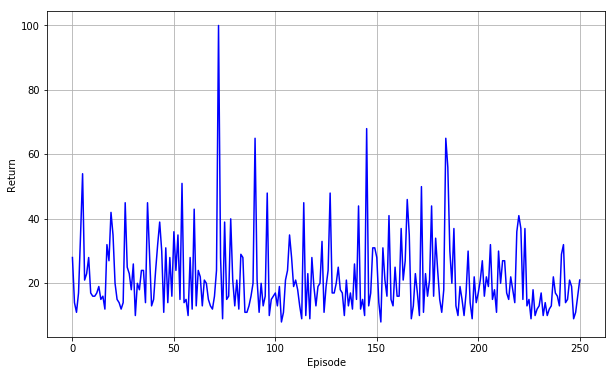

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [15]:
opt_agent.watch_me(env, steps=300)

### with adaptive noise

In [18]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 250
initial_noise_std = 0.01
population_size = 30
use_adaptive_noise = True

In [19]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise)

Start with Return Estimate G = 38.0
Episode 0 - Improved G to G_best = 60.0
Episode 2 - Improved G to G_best = 65.0
Episode 5 - Improved G to G_best = 68.0
Episode 6 - Improved G to G_best = 70.0
Episode 7 - Improved G to G_best = 78.0
Episode 8 - Improved G to G_best = 79.0
Episode 10 - Improved G to G_best = 82.0
Episode 13 - Improved G to G_best = 94.0
Episode 16 - Improved G to G_best = 118.0
Episode 18 - Improved G to G_best = 126.0
Episode 44 - Improved G to G_best = 132.0
Episode 50 - Improved G to G_best = 133.0
Episode 54 - Improved G to G_best = 142.0
Episode 63 - Improved G to G_best = 162.0
Episode 71 - Improved G to G_best = 172.0
Episode 102 - Improved G to G_best = 179.0
Episode 166 - Improved G to G_best = 190.0


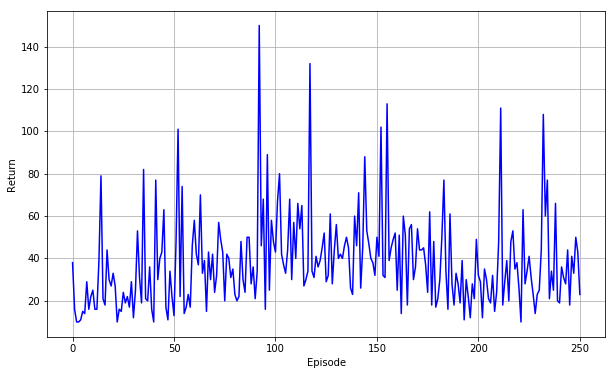

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [21]:
opt_agent.watch_me(env, steps=300)

### Use Cross Entropy Metod

In [25]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 250
initial_noise_std = 0.01
population_size = 30
cem_frac = 0.25
use_adaptive_noise = False
use_cem = True

In [26]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  cem_frac=cem_frac,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise,
                                                  use_cem=use_cem)

Start with Return Estimate G = 8.0
Episode 0 - Improved G to G_best = 40.285714285714285
Episode 5 - Improved G to G_best = 44.42857142857143
Episode 9 - Improved G to G_best = 48.857142857142854
Episode 73 - Improved G to G_best = 49.142857142857146
Episode 126 - Improved G to G_best = 49.42857142857143
Episode 167 - Improved G to G_best = 57.857142857142854


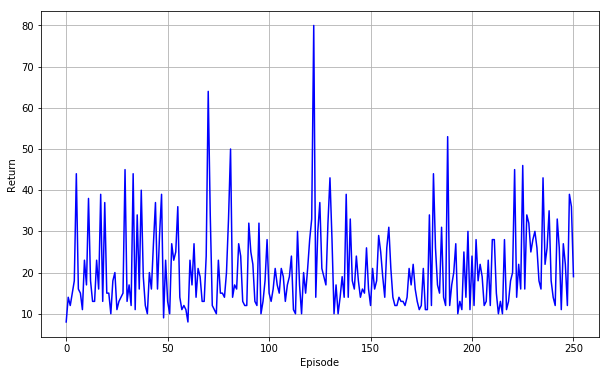

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [28]:
opt_agent.watch_me(env, steps=300)

## Use Evolution Strategy

In [29]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 250
initial_noise_std = 0.01
population_size = 10
use_adaptive_noise = True
use_evolution = True

In [30]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise,
                                                  use_evolution=use_evolution)

Start with Return Estimate G = 9.0
Episode 0 - Improved G to G_best = 20.0
Episode 13 - Improved G to G_best = 21.0
Episode 19 - Improved G to G_best = 24.0
Episode 21 - Improved G to G_best = 32.0
Episode 24 - Improved G to G_best = 40.0
Episode 47 - Improved G to G_best = 55.0


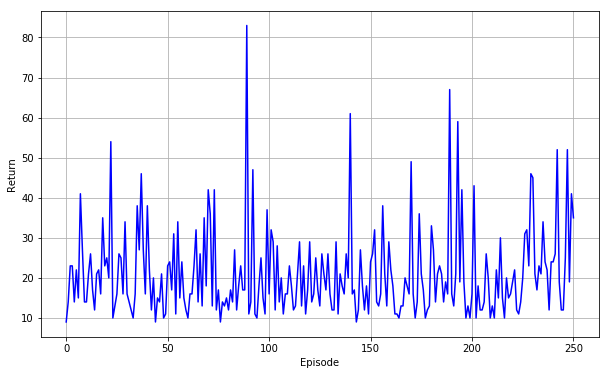

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [32]:
opt_agent.watch_me(env, steps=300)

## Hm, that still doesn't look nice

Eventually, the search space for the stochastic policy search is too complex and reducing the set of parameters might help